In [1]:
# Imports
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt


#from datetime import datetime, date

In [2]:
def combine_files(path_to_files):
    df = pd.DataFrame()
    file_list = listdir('../data/')
    for file in file_list:
        if ('.csv' in file) & (file != 'all_states.csv'):
            df = pd.concat([df, pd.read_csv(f'../data/{file}')])
    return df

In [3]:
from greykite.common.data_loader import DataLoader
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum



import warnings
from collections import defaultdict

import plotly
import pandas as pd

from greykite.common.constants import TIME_COL
from greykite.common.constants import VALUE_COL
from greykite.framework.benchmark.data_loader_ts import DataLoader
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.utils.result_summary import summarize_grid_search_results


In [4]:
import datetime

import numpy as np
import pandas as pd
import plotly

from greykite.algo.changepoint.adalasso.changepoint_detector import ChangepointDetector
from greykite.algo.forecast.silverkite.constants.silverkite_holiday import SilverkiteHoliday
from greykite.algo.forecast.silverkite.constants.silverkite_seasonality import SilverkiteSeasonalityEnum
from greykite.algo.forecast.silverkite.forecast_simple_silverkite_helper import cols_interact
from greykite.common import constants as cst
from greykite.common.features.timeseries_features import build_time_features_df
from greykite.common.features.timeseries_features import convert_date_to_continuous_time
from greykite.framework.benchmark.data_loader_ts import DataLoaderTS
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
all_states = combine_files('../data/')
all_states.head()

,state,week,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
0,Massachussetts,2017-12-31,61.0,67.0,27.0,26.0,25.0,0.0,0.0,0.0,0.0,0.0
1,Massachussetts,2018-01-07,66.0,70.0,26.0,35.0,34.0,0.0,0.0,0.0,0.0,0.0
2,Massachussetts,2018-01-14,57.0,71.0,27.0,30.0,31.0,0.0,0.0,0.0,0.0,0.0
3,Massachussetts,2018-01-21,69.0,73.0,26.0,41.0,40.0,0.0,0.0,0.0,0.0,0.0
4,Massachussetts,2018-01-28,68.0,74.0,31.0,35.0,39.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# updating the week column to be datetime type
all_states['week'] = pd.to_datetime(all_states['week'], format = '%Y-%m-%d')
all_states.dtypes

state                          object
week                   datetime64[ns]
depression                    float64
anxiety                       float64
addiction                     float64
counselling                   float64
mental_health                 float64
stay_at_home                  float64
mask_mandate                  float64
gatherings_banned             float64
business_closures             float64
travel_restrictions           float64
dtype: object

In [8]:
all_states

,state,week,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
0,Massachussetts,2017-12-31,61.0,67.0,27.0,26.0,25.0,0.0,0.0,0.0,0.0,0.0
1,Massachussetts,2018-01-07,66.0,70.0,26.0,35.0,34.0,0.0,0.0,0.0,0.0,0.0
2,Massachussetts,2018-01-14,57.0,71.0,27.0,30.0,31.0,0.0,0.0,0.0,0.0,0.0
3,Massachussetts,2018-01-21,69.0,73.0,26.0,41.0,40.0,0.0,0.0,0.0,0.0,0.0
4,Massachussetts,2018-01-28,68.0,74.0,31.0,35.0,39.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
257,Washington,2022-12-04,71.0,82.0,29.0,45.0,64.0,0.0,0.0,0.0,0.0,0.0
258,Washington,2022-12-11,72.0,71.0,24.0,40.0,54.0,0.0,0.0,0.0,0.0,0.0
259,Washington,2022-12-18,50.0,73.0,33.0,28.0,38.0,0.0,0.0,0.0,0.0,0.0
260,Washington,2022-12-25,49.0,83.0,22.0,28.0,40.0,0.0,0.0,0.0,0.0,0.0


In [9]:
all_states['covid_restrictions'] = all_states['state'].apply(lambda x: 'Most Restrictions' if (x == 'Washington') | (x == 'New York') | (x == 'California') | (x == 'Hawaii') | (x == 'Alaska') else 'Least Restrictions')

In [15]:
from pmdarima import auto_arima


In [16]:
# load your time series data
Least_Restrictions = all_states.copy()
Least_Restrictions['week'] = pd.to_datetime(Least_Restrictions['week'],format='%Y-%m-%d')
Least_Restrictions = Least_Restrictions.set_index('week')

In [17]:
Least_Restrictions = Least_Restrictions[Least_Restrictions.covid_restrictions != 'Most Restrictions'].copy()
Least_Restrictions.drop('state', axis=1, inplace=True)



In [19]:
model = auto_arima(Least_Restrictions['depression'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13284.554, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13866.703, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13523.560, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13295.945, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13864.703, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13259.228, Time=1.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13290.483, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13290.400, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13294.435, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13292.432, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13292.388, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13289.102, Time=1.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13257.316, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13288.498, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0

In [20]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1834
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -6624.658
Date:                Tue, 31 Jan 2023   AIC                          13257.316
Time:                        20:32:22   BIC                          13279.371
Sample:                             0   HQIC                         13265.450
                               - 1834                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8760      0.032     27.196      0.000       0.813       0.939
ma.L1         -1.5139      0.039    -39.018      0.000      -1.590      -1.438
ma.L2          0.5295      0.033     16.012      0.0

/Users/sheilalong/greykite-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

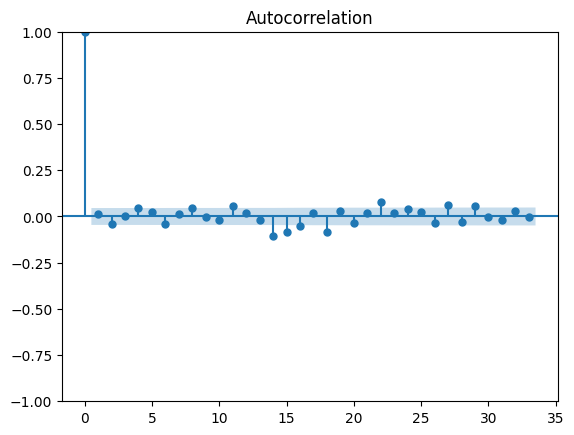

<Figure size 640x480 with 0 Axes>

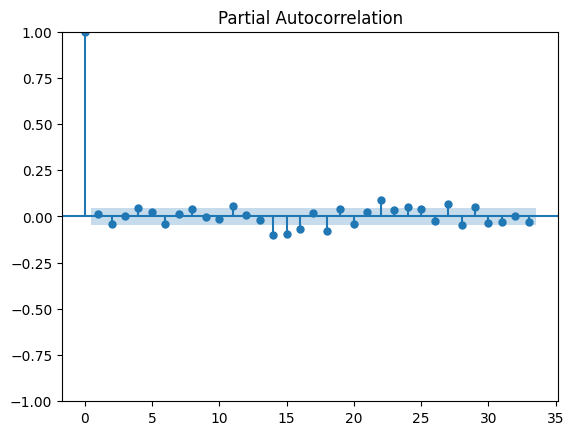

In [21]:
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

residuals = model.resid()

plt.figure()
plot_acf(residuals)

plt.figure()
plot_pacf(residuals)

plt.show()

In [22]:
# load your time series data
Most_Restrictions = all_states.copy()
Most_Restrictions['week'] = pd.to_datetime(Most_Restrictions['week'],format='%Y-%m-%d')
Most_Restrictions = Most_Restrictions.set_index('week')

In [23]:
Most_Restrictions = Most_Restrictions[Most_Restrictions.covid_restrictions != 'Most Restrictions'].copy()
Most_Restrictions.drop('state', axis=1, inplace=True)


In [25]:
model = auto_arima(Most_Restrictions['depression'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13284.554, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13866.703, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13523.560, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13295.945, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13864.703, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13259.228, Time=1.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13290.483, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13290.400, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13294.435, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13292.432, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13292.388, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13289.102, Time=1.45 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13257.316, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13288.498, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0

In [26]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1834
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -6624.658
Date:                Tue, 31 Jan 2023   AIC                          13257.316
Time:                        20:32:46   BIC                          13279.371
Sample:                             0   HQIC                         13265.450
                               - 1834                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8760      0.032     27.196      0.000       0.813       0.939
ma.L1         -1.5139      0.039    -39.018      0.000      -1.590      -1.438
ma.L2          0.5295      0.033     16.012      0.0

/Users/sheilalong/greykite-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

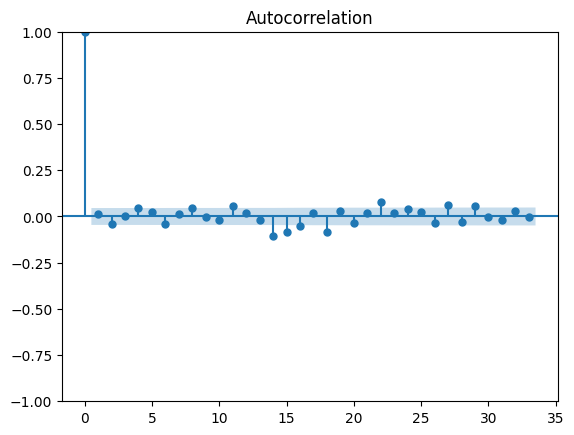

<Figure size 640x480 with 0 Axes>

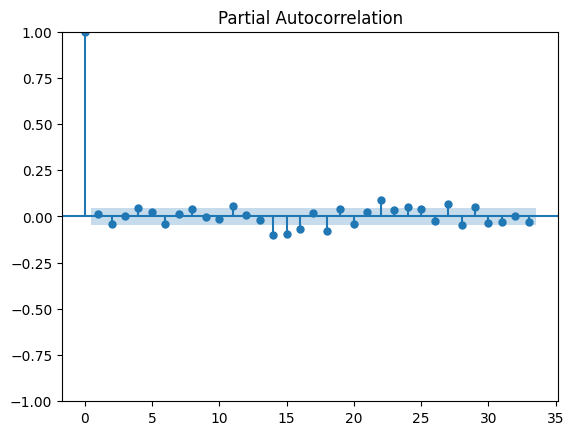

In [27]:
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

residuals = model.resid()

plt.figure()
plot_acf(residuals)

plt.figure()
plot_pacf(residuals)

plt.show()

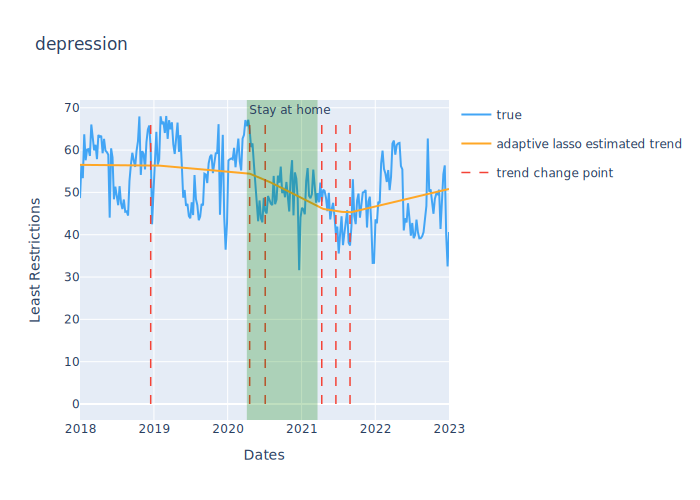

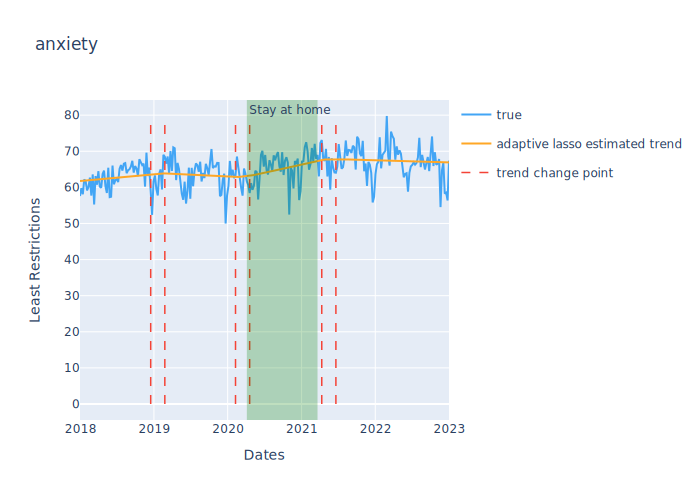

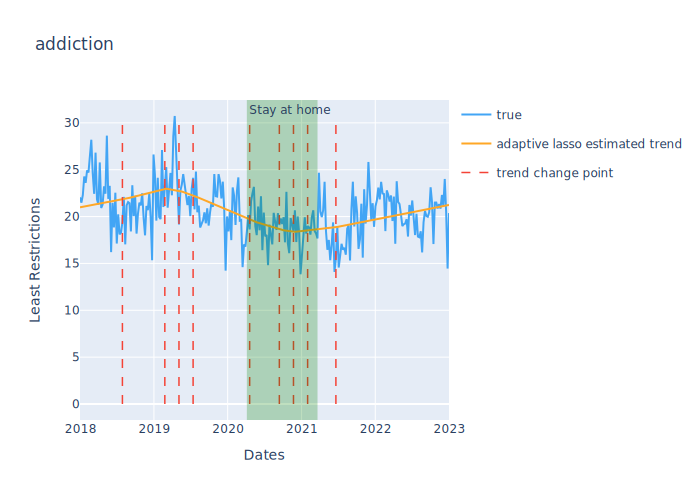

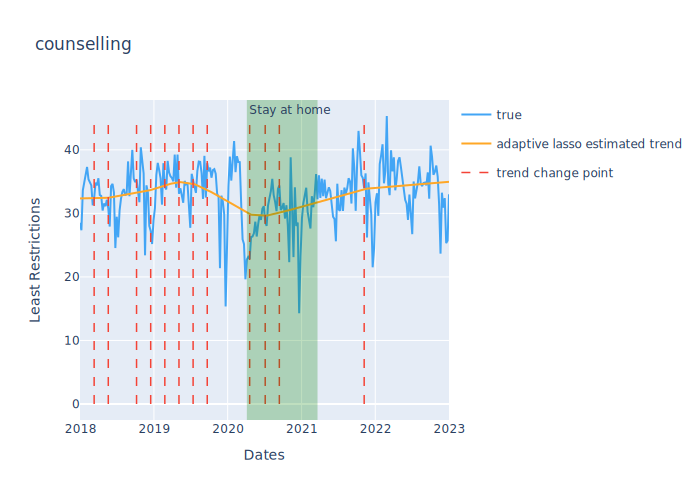

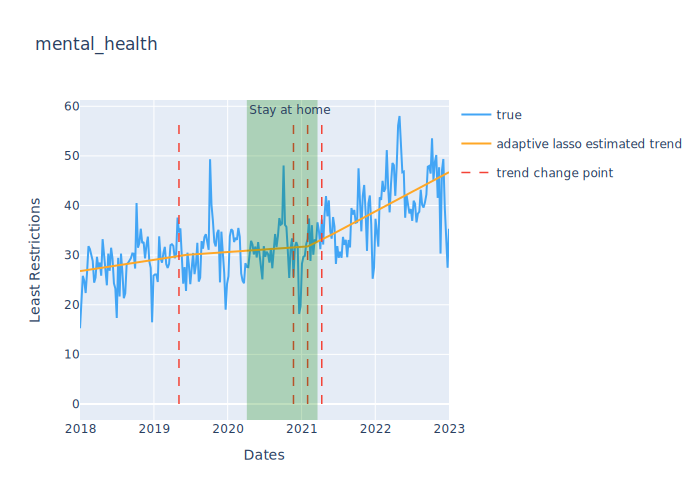

In [32]:
value_columns = ['depression', 'anxiety', 'addiction','counselling','mental_health']

for value_col in value_columns:

    new_df = all_states.groupby(['week', 'covid_restrictions']).mean(numeric_only=True).unstack('covid_restrictions')[value_col]
    model = ChangepointDetector()
    res = model.find_trend_changepoints(
        df=new_df.reset_index(), 
        time_col="week", 
        value_col='Least Restrictions', 
        yearly_seasonality_order=10,
        regularization_strength=0.5, 
        resample_freq="7D", 
        potential_changepoint_n=25, 
        yearly_seasonality_change_freq="365D",
        no_changepoint_distance_from_end="365D")
    fig = model.plot(
        observation=True,
        trend_estimate=False,
        trend_change=True,
        yearly_seasonality_estimate=False,
        adaptive_lasso_estimate=True,
        plot=False,
        )
    fig.add_vrect(x0='2020-04-05', x1="2021-03-21", 
              annotation_text="Stay at home", annotation_position="top left",
              fillcolor="green", opacity=0.25, line_width=0)

    fig.update_layout(title=value_col)
    fig.show("svg")
    #plotly.io.show(fig)

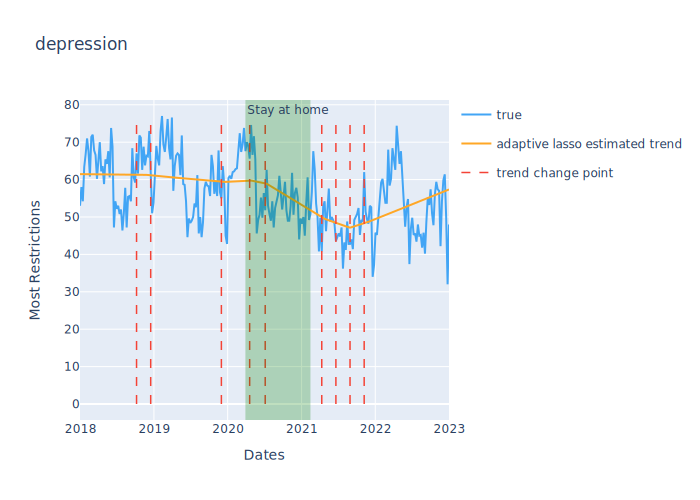

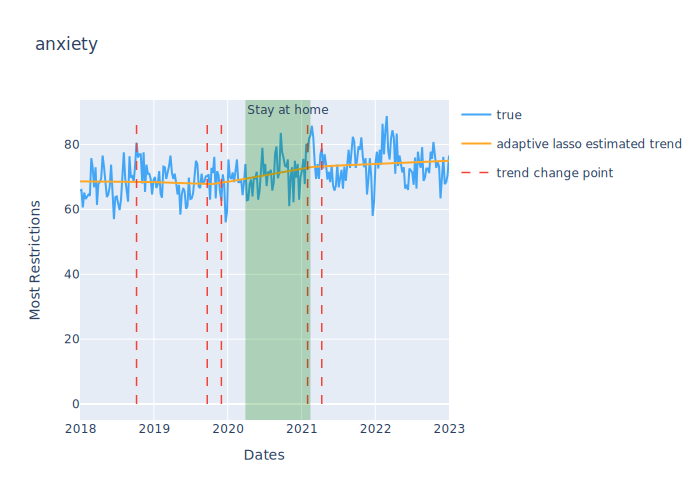

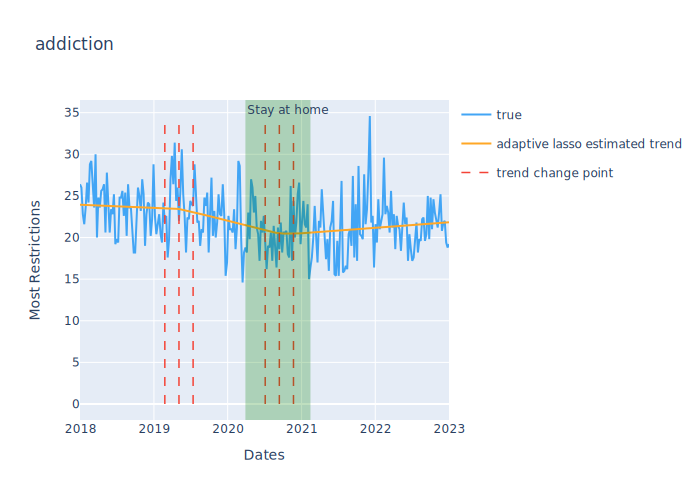

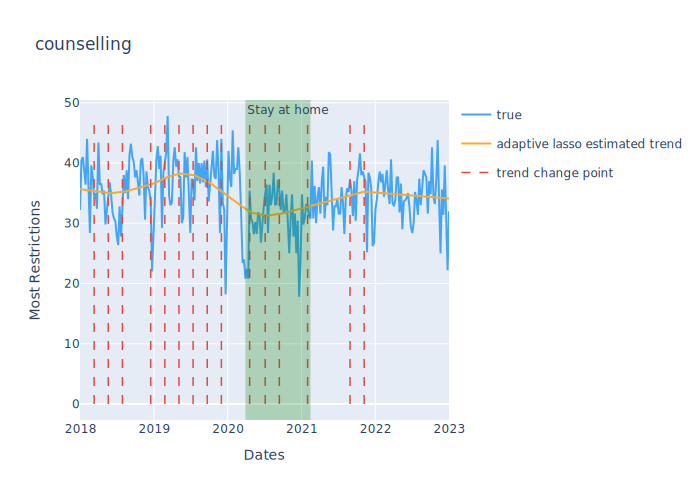

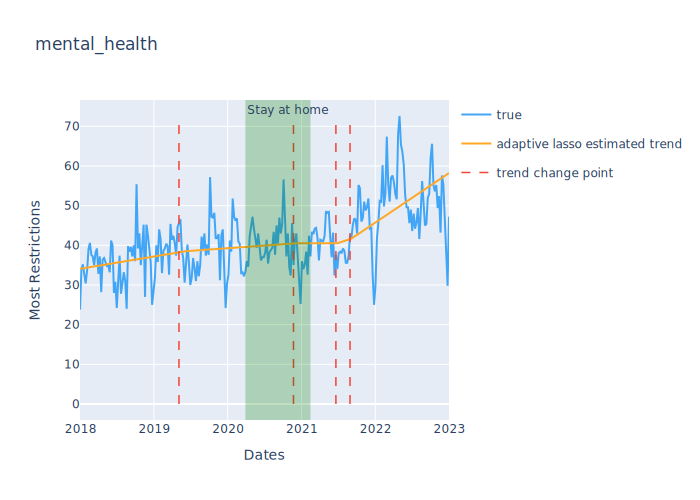

In [31]:
value_columns = ['depression', 'anxiety', 'addiction','counselling','mental_health']

for value_col in value_columns:

    new_df = all_states.groupby(['week', 'covid_restrictions']).mean(numeric_only=True).unstack('covid_restrictions')[value_col]
    model = ChangepointDetector()
    res = model.find_trend_changepoints(
        df=new_df.reset_index(), 
        time_col="week", 
        value_col='Most Restrictions', 
        yearly_seasonality_order=10,
        regularization_strength=0.5, 
        resample_freq="7D", 
        potential_changepoint_n=25, 
        yearly_seasonality_change_freq="365D",
        no_changepoint_distance_from_end="365D")
    fig = model.plot(
        observation=True,
        trend_estimate=False,
        trend_change=True,
        yearly_seasonality_estimate=False,
        adaptive_lasso_estimate=True,
        plot=False,
     
    )
    fig.add_vrect(x0='2020-03-29', x1="2021-02-14", 
              annotation_text="Stay at home", annotation_position="top left",
              fillcolor="green", opacity=0.25, line_width=0)

    fig.update_layout(title=value_col)
    fig.show("svg")
   # plotly.io.show(fig)